# Autoencoder with CNN

Current state of the 475 project that creates an Autoencoder with CNN layers
Currently on a custom dataset that has packet captures from documented Malware and Benign applications  
Trains on sequences of packets, validates using the labels

### Imports

In [6]:
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from torch import nn
from torch.utils.data import DataLoader, Dataset

import numpy as np
import pandas as pd
import hashlib

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

### Data loading

In [7]:
# Path to your dataset
dataset_path = 'C:/Users/theob/Code/Supervised Malware Detection/Dataset/USTC-TFC2016-master/1_mil_final.csv'

# Read in the dataset
df = pd.read_csv(dataset_path)

### Encode all packet features to ensure they are in numeric representation

In [8]:
# Replace any N/A value with 0
df.fillna(0, inplace=True)

# One-hot encode the protocol column of a pandas DataFrame
def one_hot_encode_protocol(df, column_name='protocol'):
    one_hot = pd.get_dummies(df[column_name], prefix=column_name, dtype=float)
    return pd.concat([df.drop(column_name, axis=1), one_hot], axis=1)

# Hash an IP address into a fixed-size integer
def hash_ip(ip_address):
    # Use SHA-256 hashing
    hashed_ip = hashlib.sha256(ip_address.encode('utf-8')).hexdigest()
    # Convert the hash to an integer
    numeric_ip = int(hashed_ip, 16) % (10 ** 10)  # Use modulo to keep integer size manageable
    return numeric_ip

# Ensure that the IP columns have string type before hashing them
df['src_ip'] = df['src_ip'].astype(str) 
df['dst_ip'] = df['dst_ip'].astype(str)

# Call the pandas method 'apply' to apply the hash_ip function to all entries in a column
df['src_ip'] = df['src_ip'].apply(hash_ip)
df['dst_ip'] = df['dst_ip'].apply(hash_ip)

# User OneHotEncoder method for the protocol columns because it only has a couple of possible values
df = one_hot_encode_protocol(df)

### Sequence Creation

In [9]:
# Sort the packets by time so the sequences have packets in order
df.sort_values(by='timing', inplace=True)

# Create sequences of packets with the same label.
def create_sequences(df, sequence_length=16):
    """
    Parameters:
    - df: DataFrame, the preprocessed DataFrame.
    - sequence_length: int, the length of each sequence.

    Returns:
    - sequences: List of np.arrays, the packet sequences.
    - sequence_labels: List of int, the labels for each sequence.
    """
    sequences = []
    sequence_labels = []
    
    # For each unique value in the 'label' column
    for label in df['label'].unique():

        # Create a dataframe from just packets with this label
        label_df = df[df['label'] == label]
        
        # Split the dataframe into chunks of size `sequence_length`
        num_sequences = len(label_df) // sequence_length
        for i in range(num_sequences):

            # Append the sequences without their time stamp features as the position in the sequence holds temporal data
            sequence = label_df.iloc[i*sequence_length : (i+1)*sequence_length]
            sequences.append(sequence.drop(['label'], axis=1).to_numpy())

            # Append the sequence label to the list of sequence labels
            sequence_labels.append(label)
    
    return sequences, sequence_labels

# Apply the function to create sequences
sequences, sequence_labels = create_sequences(df)

### Scaling the sequences

In [10]:
# Scale the sequence values to fit between 0 and 1
def scale_sequences(sequences):
    """
    Parameters:
    - sequences: List of np.arrays, the packet sequences.

    Returns:
    - scaled_sequences: List of np.arrays, the scaled packet sequences.
    """

    # Initialize the MinMaxScalar
    scaler = MinMaxScaler()
    
    # Reshape the sequences for scaling: Convert list of 2D arrays into a 2D array
    sequences_shape = sequences[0].shape
    sequences_concatenated = np.concatenate(sequences, axis=0)
    
    # Fit and transform the data
    scaled_data = scaler.fit_transform(sequences_concatenated)
    
    # Reshape back into the original list of 2D arrays
    scaled_sequences = [scaled_data[i*sequences_shape[0]:(i+1)*sequences_shape[0]] for i in range(len(sequences))]
    
    return scaled_sequences

# Apply the scaling function to your sequences
scaled_sequences = scale_sequences(sequences)

### Converting the sequences to tensors

In [11]:
def sequences_to_tensors(sequences, sequence_labels):
    """
    Convert sequences and their labels into PyTorch tensors efficiently.

    Parameters:
    - sequences: List of np.arrays, the packet sequences.
    - sequence_labels: List of int, the binary labels for each sequence.

    Returns:
    - sequence_tensors: PyTorch Tensor, the packet sequences as tensors.
    - label_tensors: PyTorch Tensor, the labels for each sequence as tensors.
    """
    # Stack the sequences into a single numpy array
    sequences_array = np.stack(sequences)
    
    # Convert the stacked array to a PyTorch tensor
    sequence_tensors = torch.tensor(sequences_array, dtype=torch.float32)
    
    # Convert labels to a tensor
    label_tensors = torch.tensor(sequence_labels, dtype=torch.long)
    
    return sequence_tensors, label_tensors

def binarize_labels(sequence_labels):
    """
    Convert sequence labels from categorical ('Benign', 'Malware') to binary (0, 1).

    Parameters:
    - sequence_labels: List of str, the categorical labels for each sequence.

    Returns:
    - binary_labels: List of int, the binary labels for each sequence.
    """
    binary_labels = [0 if label == 'Benign' else 1 for label in sequence_labels]
    return binary_labels

# Assuming `sequence_labels` contains your categorical labels
binary_sequence_labels = binarize_labels(sequence_labels)

# Now convert your sequences and the newly binarized labels into PyTorch tensors
sequence_tensors, label_tensors = sequences_to_tensors(scaled_sequences, binary_sequence_labels)

### Create train and test datasets and instantiate DataLoader objects

In [12]:
class SequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        """
        sequences: A tensor of shape [n_sequences, 16, 7] - packets per sequence and features per packet
        labels: A tensor of labels for the sequences
        """
        self.sequences = sequences
        self.labels = labels
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        # Optionally, add any sequence-specific preprocessing here
        sequence = self.sequences[idx]
        label = self.labels[idx]
        return sequence, label

class SequenceDataset2D(Dataset):
    """
    A dataset that formats sequences for 2D convolutional neural networks.
    """
    def __init__(self, sequences, labels, new_shape):
        """
        sequences: A list or array of sequences, each sequence being potentially 1D.
        labels: The corresponding labels for the sequences.
        new_shape: The new shape to reshape each sequence into, e.g., (1, 28, 28) for MNIST-like images.
        """
        self.sequences = sequences
        self.labels = labels
        self.new_shape = new_shape

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        # Reshape the sequence into the new 2D shape
        sequence_reshaped = np.reshape(self.sequences[idx], self.new_shape)
        # Convert sequence and label to tensors
        sequence_tensor = torch.tensor(sequence_reshaped, dtype=torch.float)
        label_tensor = torch.tensor(self.labels[idx], dtype=torch.long)
        return sequence_tensor, label_tensor

# Separate tensors by labels
sequences_0 = sequence_tensors[label_tensors == 0]
labels_0 = label_tensors[label_tensors == 0]

sequences_1 = sequence_tensors[label_tensors == 1]
labels_1 = label_tensors[label_tensors == 1]

# Find the minimum count to ensure an even split
min_count = min(len(sequences_0), len(sequences_1))

# Randomly sample from each group to ensure the even split
perm_0 = torch.randperm(len(sequences_0))[:min_count]
perm_1 = torch.randperm(len(sequences_1))[:min_count]

sequences_test_balanced = torch.cat((sequences_0[perm_0], sequences_1[perm_1]), dim=0)
labels_test_balanced = torch.cat((labels_0[perm_0], labels_1[perm_1]), dim=0)

# Shuffle the balanced test dataset
perm_test = torch.randperm(sequences_test_balanced.size(0))
sequences_test_balanced = sequences_test_balanced[perm_test]
labels_test_balanced = labels_test_balanced[perm_test]

new_shape = (1, 16, 8)  # Example for single-channel images

# Create the datasets
train_dataset_2d = SequenceDataset2D(sequences_0, labels_0, new_shape=new_shape)
test_dataset_2d = SequenceDataset2D(sequences_test_balanced, labels_test_balanced, new_shape=new_shape)

# Creating DataLoader objects for batching
train_loader_2d = DataLoader(train_dataset_2d, batch_size=4, shuffle=True)
test_loader_2d = DataLoader(test_dataset_2d, batch_size=4, shuffle=False)

print(f'Shape of training data: {len(train_dataset_2d)} {len(train_dataset_2d[0])}')
print(f'Shape of testing data: {len(test_dataset_2d)} {len(test_dataset_2d[0])}')

Shape of training data: 22944 2
Shape of testing data: 39502 2


C:\Users\theob\AppData\Local\Temp\ipykernel_27180\1894498520.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence_tensor = torch.tensor(sequence_reshaped, dtype=torch.float)
C:\Users\theob\AppData\Local\Temp\ipykernel_27180\1894498520.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_tensor = torch.tensor(self.labels[idx], dtype=torch.long)


### Ensure that cuda is available, else run on the CPU

In [13]:
# Check if CUDA is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


### Define our model

In [23]:
class ConvSequenceAutoencoder(nn.Module):
    def __init__(self):
        super(ConvSequenceAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=1),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.MaxPool2d(kernel_size=(1, 1), stride=2)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=(3, 3), stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = ConvSequenceAutoencoder().to(device)
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # L2 regularization
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)  # Learning rate decay
criterion = nn.MSELoss()

### Train the model

In [24]:
def train(model, train_loader, criterion, optimizer, epochs=5, patience=2):
    model.train()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, verbose=True)
    best_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(epochs):
        total_loss = 0
        for inputs, _ in train_loader:  # Assuming your DataLoader yields (inputs, _) pairs
            inputs = inputs.to(device)  # Correctly move inputs to the device here
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, inputs)  # Assuming autoencoder where inputs are targets
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}')
        
        scheduler.step(avg_loss)
        if avg_loss < best_loss:
            best_loss = avg_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve == patience:
            print('Early stopping triggered')
            break

    print('Training complete')

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Call train function
train(model, train_loader_2d, criterion, optimizer, epochs=5)

C:\Users\theob\AppData\Local\Temp\ipykernel_27180\1894498520.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence_tensor = torch.tensor(sequence_reshaped, dtype=torch.float)
C:\Users\theob\AppData\Local\Temp\ipykernel_27180\1894498520.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_tensor = torch.tensor(self.labels[idx], dtype=torch.long)


Epoch 1/5, Loss: 0.1569
Epoch 2/5, Loss: 0.1495
Epoch 3/5, Loss: 0.1493
Epoch 4/5, Loss: 0.1493
Epoch 5/5, Loss: 0.1492
Training complete


### Evaluate

C:\Users\theob\AppData\Local\Temp\ipykernel_27180\1894498520.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence_tensor = torch.tensor(sequence_reshaped, dtype=torch.float)
C:\Users\theob\AppData\Local\Temp\ipykernel_27180\1894498520.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_tensor = torch.tensor(self.labels[idx], dtype=torch.long)


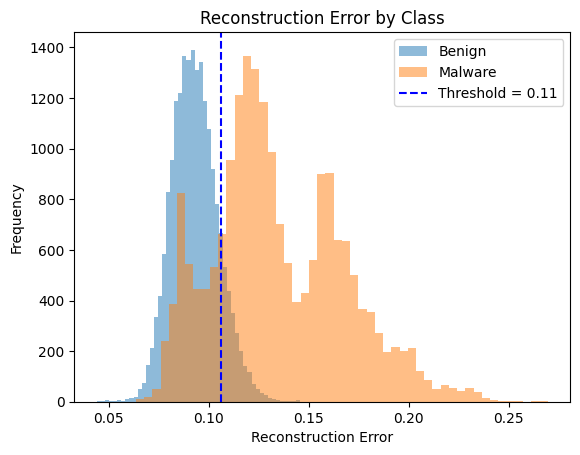

Accuracy: 84.05%


In [28]:
def evaluate_model(model, test_loader, threshold):
    model.eval()  # Set the model to evaluation mode
    reconstruction_errors = []
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            mse = ((outputs - inputs) ** 2).mean(dim=(1,2,3))  # Ensure this matches the dimensionality of your data
            reconstruction_errors.append(mse)
            pred = (mse > threshold).int()  # Convert to int; anomalous if error is above the threshold
            predictions.extend(pred.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Flatten the reconstruction errors list
    reconstruction_errors = torch.cat(reconstruction_errors).cpu().numpy()
    
    # Split errors by label for plotting
    benign_errors = reconstruction_errors[np.array(true_labels) == 0]
    malware_errors = reconstruction_errors[np.array(true_labels) == 1]
    
    # Plotting
    plt.hist(benign_errors, bins=50, alpha=0.5, label='Benign')
    plt.hist(malware_errors, bins=50, alpha=0.5, label='Malware')

    
    # Threshold line
    plt.axvline(x=threshold, color='blue', linestyle='--', label=f'Threshold = {threshold:.2f}')
    plt.legend()
    plt.xlabel('Reconstruction Error')
    plt.ylabel('Frequency')
    plt.title('Reconstruction Error by Class')
    plt.show()
    
    # Accuracy calculation
    accuracy = accuracy_score(true_labels, predictions)  # Ensure both are in compatible formats
    print(f'Accuracy: {accuracy*100:.2f}%')

    return accuracy, benign_errors, malware_errors

threshold = 0.106
# Call the evaluation function
accuracy, benign_errors, malware_errors = evaluate_model(model, test_loader_2d, threshold)

### Visualize sample inputs and reconstructed output side by side

C:\Users\theob\AppData\Local\Temp\ipykernel_27180\1894498520.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sequence_tensor = torch.tensor(sequence_reshaped, dtype=torch.float)
C:\Users\theob\AppData\Local\Temp\ipykernel_27180\1894498520.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_tensor = torch.tensor(self.labels[idx], dtype=torch.long)


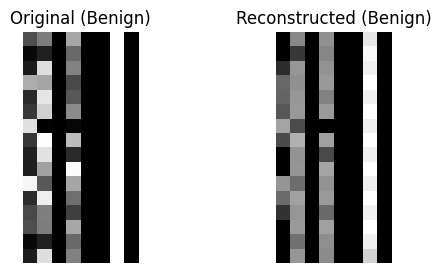

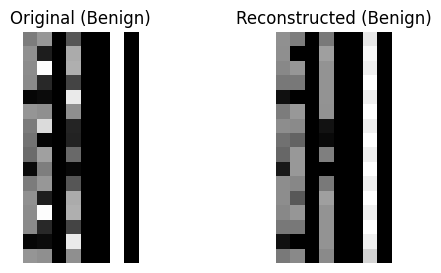

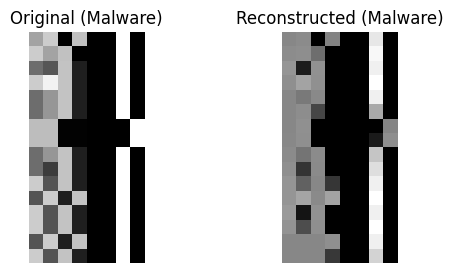

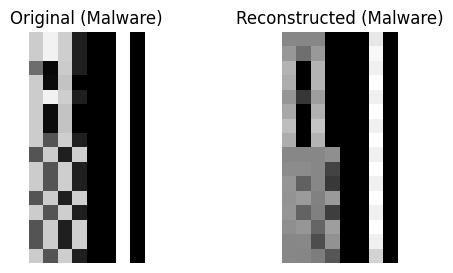

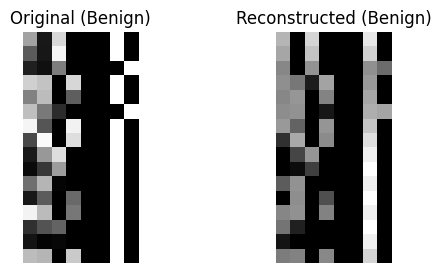

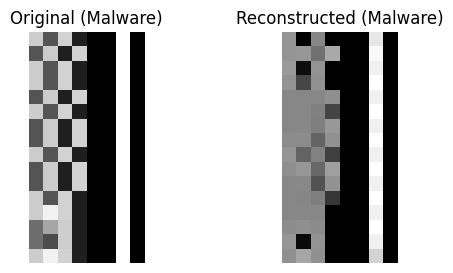

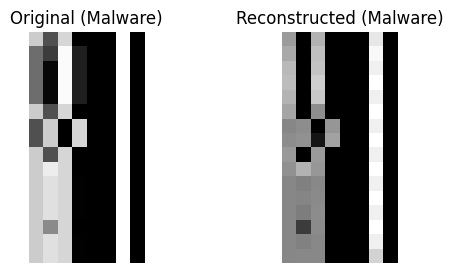

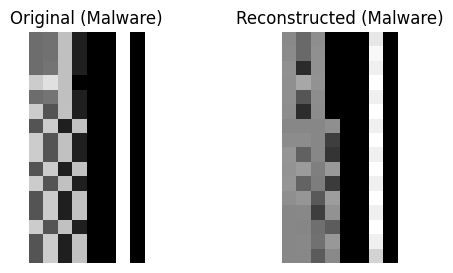

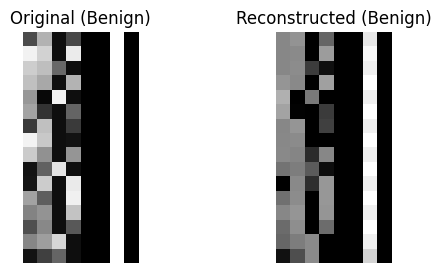

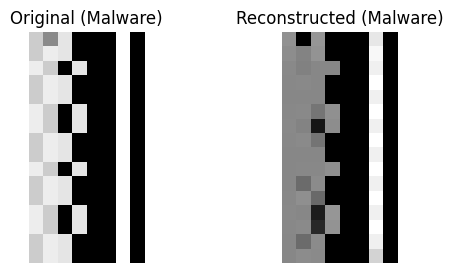

In [29]:
def visualize_reconstructions(model, test_loader_2d, num_images=10):
    model.eval()  # Set the model to evaluation mode
    images_displayed = 0

    with torch.no_grad():
        for inputs, labels in test_loader_2d:
            if images_displayed >= num_images:
                break  # Stop after displaying the specified number of images
            inputs = inputs.to(device)
            outputs = model(inputs)
            
            # Assuming inputs and outputs are now [batch_size, channels, height, width]
            for original, reconstructed, label in zip(inputs, outputs, labels):
                if images_displayed >= num_images:
                    break

                label_text = 'Malware' if label.item() == 1 else 'Benign'
                
                # Remove the channel dimension for visualization
                original = original.squeeze().cpu().numpy()  # Squeeze here
                reconstructed = reconstructed.squeeze().cpu().numpy()  # And here
                
                plt.figure(figsize=(6, 3))
                
                # Plot the original image with label
                plt.subplot(1, 2, 1)
                plt.imshow(original, cmap='gray')  # Adjusted
                plt.title(f'Original ({label_text})')
                plt.axis('off')
                
                # Plot the reconstructed image
                plt.subplot(1, 2, 2)
                plt.imshow(reconstructed, cmap='gray')  # Adjusted
                plt.title(f'Reconstructed ({label_text})')
                plt.axis('off')
                
                plt.show()
                
                images_displayed += 1

visualize_reconstructions(model, test_loader_2d)